Here we do nested 10-fold CV. We have an outter loop split into (train + validation, test)  where we have unseen test data. We then have an inner loop splitting the outter train + validation into (train, validation). 

First, in the outer loop, we run feature selection:
1. Feature selection is conducted using ElasticNet with l1 = 0.05 and alpha = 1. We found that for this dataset, ElasticNetCV consistenly chooses an alpha near 1 regardless and 

In the inner loop we do the following:

1. Feature selection: This is conducted only on the train data (to allow for generalization to validation during hyperparameter tuning). We use 5-fold elastic net CV on the train data, selecting those features that were retained 80% of the time across 100 iterations. CV chooses the best alpha, while we set the L1 ratio to 0.1 to help ensure that approximately 10-20% of the features are selected for. 
2. Hyperparameter tuning: The model is fit on the training data for the selected features, and assessed on the validation data. Across the inner 10-folds, we identify the set of hyperparameters that minimize the MSE. 



In [1]:
import os
from multiprocessing import Pool
from collections import Counter

from tqdm import trange 

import pandas as pd
import numpy as np

from scipy import stats

from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
res_all_fn = os.path.join(data_path, 'interim', 'iteration_all_res.json')

In [3]:
n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [4]:
n_splits_outer = 10
n_splits_inner = 10

# feature selection elastic_net
# n_alphas = 50 # fewer numbers is less accurate but faster computationally, default is 100
# n_splits_elastic = 5 # fewer is faster but less rigorous
n_iter_elastic = int(1e2) # fewer is faster but less rigorous
feature_thresh_inner = 0.8
par_feature = False # parallelization on feature selection

feature_thresh_outer = 0.6 # the fraction of inner folds across which a feature should have been selected to be considered a consensus feature

In [5]:
def flatten_list(nested_list):
    """
    Flattens a list of lists into a single list.
    """
    return [item for sublist in nested_list for item in sublist]

def write_res(res_all):
    with open(res_all_fn, "w") as json_file:
        json.dump(res_all, json_file, indent=4)  

# def elastic_netcv_iteration(X, y, seed_, n_splits, n_cores, n_alphas):
#     """
#     Perform a single iteration of ElasticNetCV for feature selection.
#     """
#     elastic_net = ElasticNetCV(l1_ratio = 0.1, 
#                                cv=n_splits, 
#                                n_alphas = n_alphas, 
#                                random_state=seed_, 
#                                n_jobs = n_cores)
#     elastic_net.fit(X, y.values.ravel())
#     selected_features = np.where(elastic_net.coef_ != 0)[0]
#     return selected_features

def elastic_net_iteration(X, y, seed_):
    """
    Perform a single iteration of ElasticNet for feature selection.
    """
    elastic_net = ElasticNet(l1_ratio = 0.1,
                             alpha = 1,
                             random_state=seed_)
    elastic_net.fit(X, y.values.ravel())
    selected_features = np.where(elastic_net.coef_ != 0)[0]
    return selected_features

In [6]:
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential.csv'), index_col = 0)
X = pd.read_csv(os.path.join(data_path, 'processed', 'expr.csv'), index_col = 0).transpose()

if os.path.isfile(res_all_fn):
    with open(res_all_fn, 'r') as file:
        res_all = json.load(file)
else:
    res_all = {}

# Start2

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange
import sys
sclembas = '/home/hmbaghda/Projects/scLEMBAS'
sys.path.insert(1, os.path.join(sclembas))
from scLEMBAS.model.model_components import FCLayers
from scLEMBAS.model.lr_schedulers import WarmupCosineAnnealingWarmRestarts, CosineAnealingWarmRestartsWeightDecay
from scLEMBAS.utilities import set_seeds

device = "cuda" if torch.cuda.is_available() else "cpu"


In [40]:
from scLEMBAS.model.model_components import *
class FCLayers(nn.Module):
    """
    Generates standard, fully-connected neural-network.
    Adapted from scVI's `FCLayers`.
    """
    DEFAULT_HYPER_PARAMS = {'batch_momentum': 0.01, 'layer_norm': False, 'dropout_rate': 0.1,
                        'activation_fn': nn.ReLU, # can make as None to have purely linear
                        }
    def __init__(self, layers: List[int],
                 batch_momentum: float = 0.01,
                 layer_norm: bool = False,
                 dropout_rate: int | float = 0.1,
                 activation_fn: nn.Module | None = nn.ReLU,
                 dtype: torch.dtype=torch.float32,
                 device: str = 'cpu', 
                ):
        """Initialize encoder.

        Parameters
        ----------
        layers : List[int]
            the size of each layer (including inputs and outputs)
            each element in the list corresponds to one hidden layer (i.e., no. of hidden layers = length of list)
        batch_momentum : float, optional
            `momentum` parameter for `BatchNorm` layer, by default .01
            If None, a `BatchNorm` is not added
        layer_norm : bool, optional
            whether to have `LayerNorm` layers or not, by default False
        dropout_rate : int | float, optional
            dropout rate to apply to each of the hidden layers, by default 0.1
            If None, dropout is not added
        activation_fn : nn.Module | None, optional
            non-linear Pytorch activation function, by default nn.ReLU. No activation if set to None
        linear_output : bool, optional
            whether the final layer in the encoder should only be linear (True) or incorporate the specified `activation_fn` (False)
        device : str
            whether to use gpu ("cuda") or cpu ("cpu"), by default "cpu"
        dtype : torch.dtype, optional
            datatype to store values in torch, by default torch.float32
        """
        super().__init__()

        # set up params
        self.batch_momentum = batch_momentum
        self.layer_norm = layer_norm
        self.dropout_rate = dropout_rate
        self.activation_fn = activation_fn
        self.dtype = dtype
        self.device = device

        if self.batch_momentum and self.layer_norm:
            warnings.warn('You have applied both a batch- and layer-normalization. Recommended to choose one of the two.')

        fc_layers = OrderedDict()
        for i, (n_in, n_out) in enumerate(zip(layers[:-1], layers[1:])):
                fc_layers['FC Layer {}'.format(i)] = self._single_layer(n_in,n_out)#, drop_keys = None)
        self.fc_layers = nn.Sequential(fc_layers)

    def _single_layer(self, n_in: int, n_out: int):#, drop_keys: Optional[List[str]] = None):
        """Creates a single [set of] layer[s] in the encoder."""

        all_layers = OrderedDict([('linear', nn.Linear(in_features = n_in, out_features = n_out, bias = True, 
                                                       device = self.device, dtype = self.dtype)),
                                  ('batch normalization', nn.BatchNorm1d(n_out, momentum=self.batch_momentum, 
                                                                         device = self.device, dtype = self.dtype) if self.batch_momentum else None),
                                  ('layer normalization', nn.LayerNorm(n_out, elementwise_affine=False, 
                                                                       device = self.device, dtype = self.dtype) if self.layer_norm else None),
                                  ('activation', self.activation_fn() if self.activation_fn else None),
                                  ('dropout', nn.Dropout(p=self.dropout_rate) if (self.dropout_rate and self.dropout_rate > 0) else None)])

        self._initialize_weights(all_layers['linear'])  # Initialize weights based on activation function
        layer = nn.Sequential(OrderedDict((k, v) for k, v in all_layers.items() if v is not None))
        return layer
    
    def _initialize_weights(self, layer):
        """Initialize weights based on the activation function."""
        if isinstance(self.activation_fn, type):
            if self.activation_fn == nn.ReLU:
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            elif self.activation_fn == nn.LeakyReLU:
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='leaky_relu')
            elif self.activation_fn == nn.Tanh or issubclass(self.activation_fn, nn.Tanh):
                nn.init.xavier_uniform_(layer.weight)
            elif self.activation_fn == nn.Sigmoid or issubclass(self.activation_fn, nn.Sigmoid):
                nn.init.xavier_uniform_(layer.weight)
            else:
                nn.init.kaiming_uniform_(layer.weight)  # Default to He initialization
        else:
            nn.init.kaiming_uniform_(layer.weight)  # Default initialization

        if layer.bias is not None:
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.fc_layers(x)   

In [28]:
import random
def set_seed(seed):
    if 'CUBLAS_WORKSPACE_CONFIG' not in os.environ.keys():
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [10]:
n_splits_outer = 10
outer_cv = KFold(n_splits=n_splits_outer, shuffle=True, random_state=seed)
for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    if outer_idx not in res_all:
        res_all[outer_idx] = {}
    X_outer_train, X_outer_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_outer_train, y_outer_test = y.iloc[train_idx,:], y.iloc[test_idx,:]
    break

In [11]:
elastic_net = ElasticNet(l1_ratio = 0.05,
                         alpha = 1,
                         random_state=seed)
elastic_net.fit(X_outer_train, y_outer_train.values.ravel())
selected_features = np.where(elastic_net.coef_ != 0)[0]

In [12]:
len(selected_features)

932

In [746]:
X_train = X_outer_train.iloc[:, selected_features].copy()
y_train = y_outer_train

In [715]:
model = ExtraTreesRegressor(n_jobs = n_cores,
                              random_state = seed,
                              n_estimators = 800, 
                           bootstrap = True)
model.fit(X_train, y_outer_train)
y_pred = model.predict(X_outer_test.iloc[:, selected_features])
stats.pearsonr(y_pred, 
                y_outer_test.values.flatten()).statistic

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.27089438027213614

In [41]:
def ffn_train(X_train, y_train, X_test, y_test, selected_features, seed, 
             activation_fn = nn.LeakyReLU):
    X_train_FFN = torch.tensor(X_train.iloc[:, selected_features].values, device = device)
    y_train_ffn = torch.tensor(y_train.values, device = device)

    ffn_train_loader = DataLoader(TensorDataset(X_train_FFN, y_train_ffn), 
                                  batch_size=50, 
                                  shuffle=True, 
                                 worker_init_fn=lambda _: np.random.seed(seed))

    n_layers_ffn = 1
    ffn_layers = list(np.round(np.linspace(X_train_FFN.shape[1], y_train_ffn.shape[1], n_layers_ffn + 2)).astype(int))
    min_lr = 2e-6#1e-6
    max_lr = 1e-3
    gamma = 1
    n_epochs = 750
    restart_epoch = int(n_epochs/5)
    # reset_epoch = int(n_epochs/3)
    warmup_steps = int(n_epochs/10)

    set_seeds(seed)
    mod_ffn = FCLayers(layers = ffn_layers, dtype = torch.float64, device = device, 
                      activation_fn = activation_fn, dropout_rate = 0.25)
    ffn_optimizer = torch.optim.Adam(mod_ffn.parameters(),
                                     lr=min_lr,
                                     weight_decay=2)

    ffn_loss_fn = nn.MSELoss()

    reset_state = ffn_optimizer.state.copy()
    lr_scheduler = WarmupCosineAnnealingWarmRestarts(optimizer = ffn_optimizer,
                                                          T_0 = restart_epoch,
                                                          T_mul = 1, 
                                                          gamma = gamma,
                                                          eta_min = min_lr,
                                                          max_lr=max_lr,
                                                          warmup_steps = warmup_steps,
                                                          last_epoch = -1)
    
#     loss_tracker = []
#     lr_tracker = []
    for e in trange(n_epochs):
        mod_ffn.train()
#         lr_tracker.append(ffn_optimizer.param_groups[0]['lr'])
#         loss_tracker_batch = []
        for X_batch, y_batch in ffn_train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred_ffn = mod_ffn(X_batch)
            ffn_loss = ffn_loss_fn(y_pred_ffn, y_batch)

            ffn_optimizer.zero_grad()
            ffn_loss.backward()
            ffn_optimizer.step()

#             loss_tracker_batch.append(ffn_loss.detach().cpu().numpy().item())

            del X_batch, y_batch
            torch.cuda.empty_cache()
        lr_scheduler.step()
#         loss_tracker.append(np.mean(loss_tracker_batch))
    #     if np.logical_and(e % reset_epoch == 0, e>0):
    #         ffn_optimizer.state = reset_state.copy()

    mod_ffn.eval()
    with torch.no_grad():
        y_pred_ffn = mod_ffn(torch.tensor(X_test.iloc[:, selected_features].values, 
                                     device = device))
    return stats.pearsonr(y_pred_ffn.detach().cpu().numpy().reshape(-1,),
                          y_test.values.flatten()).statistic

In [1066]:
# elastic_net = ElasticNet(l1_ratio = 0.05,
#                          alpha = 1,
#                          random_state=seed)
# elastic_net.fit(X_outer_train, y_outer_train.values.ravel())
# selected_features = np.where(elastic_net.coef_ != 0)[0]

In [50]:
ffn_train(X_train = X_outer_train, 
              y_train = y_outer_train, 
              X_test = X_outer_test, 
              y_test = y_outer_test, 
              selected_features = selected_features,
              seed = i, 
          activation_fn = nn.LeakyReLU)

100%|███████████████████████████████████████████| 750/750 [00:15<00:00, 48.77it/s]


0.09154262972593505

In [36]:
import seaborn as sns

<Axes: ylabel='Density'>

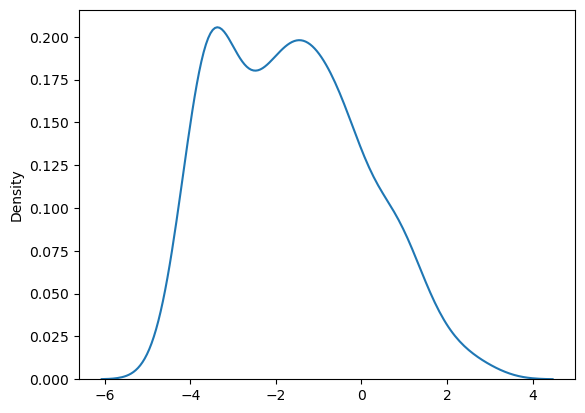

In [37]:
sns.kdeplot(y.values.flatten())

In [33]:
X

,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3,snoZ196
2313287,0.000000,0.361267,-0.646164,-1.240694,1.385542,0.000000,0.514715,0.776964,0.0,0.000000,...,0.000000,-0.618013,-1.104138,-0.874854,0.000000,-0.272305,-0.349190,-1.514422,-0.410085,-1.615455
769P,0.000000,0.851085,-0.646164,-1.240694,1.748360,0.000000,0.514715,-0.123868,0.0,0.000000,...,0.000000,-0.389435,-0.389684,0.738823,0.000000,-0.743516,1.297770,0.000000,0.269466,0.423022
786O,0.905367,-0.429553,-1.014824,-1.358556,0.120203,0.000000,-0.650372,0.000000,0.0,1.462345,...,0.000000,-0.618013,-0.844595,-0.874854,0.000000,0.471211,1.578794,-0.262431,0.182760,1.442261
A172,1.913299,-0.878445,3.234603,1.714307,0.000000,0.000000,-0.650372,-0.123868,0.0,0.792389,...,0.380143,-0.389435,1.163990,1.132942,0.000000,-0.132568,1.122896,1.155064,-1.869287,-0.751144
A2780,0.000000,-0.064835,0.286649,0.355751,0.000000,0.182757,2.072965,1.303917,0.0,0.000000,...,0.380143,0.468016,-0.844595,0.855259,0.000000,1.726010,-1.035107,0.000000,0.513227,1.442261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UACC257,0.000000,0.676816,0.553513,0.631693,0.000000,3.854433,1.067862,-0.123868,0.0,0.000000,...,-0.490090,0.000000,0.340837,-0.798983,3.472576,0.775623,-1.533468,0.236142,1.248990,-1.615455
UMUC1,0.000000,-1.013468,-0.309605,-1.358556,0.000000,0.000000,0.000000,0.113082,0.0,0.000000,...,-0.490090,0.000000,-0.389684,-0.874854,0.000000,-1.113362,-0.259128,-0.405472,-0.767535,0.423022
WM2664,2.116255,-0.500138,1.666266,1.358556,0.000000,1.886366,-0.414108,0.000000,0.0,0.792389,...,0.380143,-1.176308,0.783399,-0.353555,0.301264,-0.132568,0.845255,0.551202,-1.679751,0.000000
YAPC,2.116255,1.410717,-0.646164,-1.240694,0.000000,0.000000,0.664996,-0.123868,0.0,0.000000,...,0.380143,0.168860,0.175747,-0.664567,0.000000,-2.368160,-1.035107,-1.763015,-1.869287,-1.615455


In [43]:
pearson_all = []
for i in range(3):
    pr = ffn_train(X_train = X_outer_train, 
              y_train = y_outer_train, 
              X_test = X_outer_test, 
              y_test = y_outer_test, 
              selected_features = selected_features,
              seed = i)
    pearson_all.append(pr)

100%|███████████████████████████████████████████| 750/750 [00:17<00:00, 43.86it/s]


In [44]:
np.mean(pearson_all)

0.202026607278123

In [46]:
pearson_all

[-0.12394513797575236, 0.27017837084936064, 0.202026607278123]

In [17]:
np.median(pearson_all)

0.21719158757330015

In [18]:
np.std(pearson_all)

0.09961781556892882

# Start

In [178]:
from sklearn.ensemble import ExtraTreesRegressor
# import xgboost as xgb
# from sklearn.feature_selection import RFE


In [17]:
n_splits_outer = 10
n_splits_inner = 10

# feature selection elastic_net
# n_alphas = 50 # fewer numbers is less accurate but faster computationally, default is 100
# n_splits_elastic = 5 # fewer is faster but less rigorous
n_iter_elastic = 1 # fewer is faster but less rigorous
feature_thresh_inner = 0.8
par_feature = False # parallelization on feature selection

feature_thresh_outer = 0.6 # the fraction of inner folds across which a feature should have been selected to be considered a consensus feature


best_mse_params = {'n_estimators': np.int64(850),
 'max_features': 1,
 'max_samples': None,
 'max_depth': 25,
 'min_samples_split': np.int64(2),
 'min_samples_leaf': np.int64(1)}

In [21]:
res_all = {}

In [22]:
np.where(elastic_net.coef_ != 0)[0]

array([    0,    14,    15, ..., 32124, 32129, 32138])

In [24]:
# outer_cv = KFold(n_splits=n_splits_outer, shuffle=True, random_state=seed)
# for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
#     if outer_idx not in res_all:
#         res_all[outer_idx] = {}
#     X_outer_train, X_outer_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
#     y_outer_train, y_outer_test = y.iloc[train_idx,:], y.iloc[test_idx,:]

#     # set up inner loop
#     inner_cv = KFold(n_splits=n_splits_inner, shuffle=True, random_state=seed)
#     inner_selected_features = []
#     inner_best_params = []
    
#     # FEATURE SELECTION
#     elastic_net = ElasticNet(l1_ratio = 0.01,
#                              alpha = 1,
#                              random_state=seed)
#     elastic_net.fit(X_outer_train, y_outer_train.values.ravel())
#     selected_features = np.where(elastic_net.coef_ != 0)[0]
    
# #     for inner_idx, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train)):
# #         print('outer: {}, inner: {}'.format(outer_idx, inner_idx))
# #         if inner_idx not in res_all[outer_idx]:
# #             res_all[outer_idx][inner_idx] = {}
# #         X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx,:], X_outer_train.iloc[inner_val_idx,:]
# #         y_inner_train, y_inner_val = y_outer_train.iloc[inner_train_idx,:], y_outer_train.iloc[inner_val_idx,:]
        
# #         # FEATURE SELECTION - on inner train
# #         if 'selected_features' not in res_all[outer_idx][inner_idx]:
# #             ec_seeds = range(n_iter_elastic)
# #             if not par_feature:
# #                 selected_features_res = []
# #                 for feature_iter in trange(n_iter_elastic):
# #                     selected_features = elastic_net_iteration(X = X_inner_train, 
# #                                                               y = y_inner_train, 
# #                                                               seed_ = ec_seeds[feature_iter])
# #                     selected_features_res.append(selected_features)
# #             else:
# #                 pool = Pool(processes = min(n_cores, n_iter_elastic))
# #                 par_inputs = [(X_inner_train, y_inner_train, seed) for seed in ec_seeds]
# #                 selected_features_res = pool.starmap(elastic_net_iteration, par_inputs)
# #                 del par_inputs
# #                 pool.close()
# #                 pool.join()
# #                 gc.collect()


# #             feature_counter = dict(zip(list(range(X_inner_train.shape[1])), [0]*X_inner_train.shape[1]))
# #             for selected_features in selected_features_res:
# #                 for sf_idx in selected_features:
# #                     feature_counter[sf_idx] += 1
# #             selected_features = [k for k,v in feature_counter.items() if v >= (n_iter_elastic * feature_thresh_inner)]
# #             selected_features = X_inner_train.columns[selected_features].tolist()

# #             res_all[outer_idx][inner_idx]['selected_features'] = selected_features
# #             write_res(res_all) # checkpoint 1
#         # HYPERPARAMETER TUNING
    
# #     # consensus features across inner folds
# #     feature_counts = Counter(flatten_list([v['selected_features'] for v in res_all[outer_idx].values()]))
# #     consensus_features = [k for k,v in feature_counts.items() if v >= (n_splits_inner * feature_thresh_outer)]
# #     res_all[outer_idx]['consensus_features'] = consensus_features
    
# #     X_outer_train_selected = X_outer_train.iloc[:, consensus_features]
# #     X_outer_test_selected = X_outer_test.iloc[:, consensus_features]
    
#     # consensus hyperparams
# #     model = ExtraTreesRegressor(n_jobs = n_cores,
# #                                   random_state = seed,
# #                                   n_estimators = 800)
#     model = ExtraTreesRegressor(n_jobs = n_cores,
#                                   random_state = seed,
#                                   n_estimators = 800, 
#                                bootstrap = True)
# #     selector = RFE(model, 
# #                    n_features_to_select=int(np.round(X.shape[1]*0.1)), # select 10% of features 
# #                    step = 2500)
# #     selector.fit(X_outer_train, y_outer_train.values.flatten())
# #     selected_features = selector.feature_names_in_[selector.support_]
# #     selected_features = np.where(selector.support_)[0]

# #     model = xgb.XGBRegressor(n_estimators=100, random_state=seed, n_jobs = n_cores, 
# #                             reg_lambda = 2)
# #     y_outer_pred = selector.predict(X_outer_test)
#     # model.fit(X_outer_train.loc[:, selected_features], y_outer_train)
#     # test_2 = model.predict(X_outer_test.loc[:, selected_features])
    
    
#     # model fitting
#     if 'stats' not in res_all[outer_idx]:
#         res_all[outer_idx]['stats'] = {}
#     if 'prediction_pearson' not in res_all[outer_idx]['stats']:
# #         y_outer_pred = selector.predict(X_outer_test)
#         model.fit(X_outer_train.iloc[:, selected_features], y_outer_train)
#         y_outer_pred = model.predict(X_outer_test.iloc[:, selected_features])
#         res_all[outer_idx]['stats']['prediction_pearson'] = stats.pearsonr(y_outer_pred, y_outer_test.values.flatten()).statistic
#         print(res_all[outer_idx]['stats']['prediction_pearson'])
# #         write_res(res_all) # checkpoint 1

In [ ]:
int(np.round(X.shape[1]*0.15))

In [ ]:
elastic_net = ElasticNet(l1_ratio = 0.01,
                         alpha = 1,
                         random_state=seed)
elastic_net.fit(X_outer_train, y_outer_train.values.ravel())
consensus_features = np.where(elastic_net.coef_ != 0)[0]

In [274]:
len(consensus_features)

3832

In [272]:
stats.pearsonr(selector.predict(X_outer_test), y_outer_test.values.flatten())

PearsonRResult(statistic=0.1982855043447539, pvalue=0.3644253374245646)

/nobackup/users/hmbaghda/Software/miniforge3/envs/mp_2/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor(bootstrap=True, n_jobs=30, random_state=42)

In [267]:
np.allclose(test, test_2)

True

In [264]:
test_2

array([-2.00096756, -1.73393443, -2.26426085, -2.43565302, -1.94198027,
       -1.0311324 , -1.19346545, -2.08203076, -1.10759032, -1.146617  ,
       -1.57278024, -2.18564451, -1.49859339, -1.87226324, -1.36567749,
       -1.62575793, -0.87427337, -2.2480171 , -1.4917877 , -1.21215907,
       -1.70336497, -0.99397355, -0.43938139])

In [255]:
selector.estimator.predict(X_outer_train.loc[:, selected_features])

NotFittedError: This ExtraTreesRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [249]:
selector.transform(X_outer_train).shape

(205, 643)

In [248]:
len(selected_features)

643

In [196]:
all_pearsons = []
for outer_idx in range(n_splits_outer):
    all_pearsons.append(res_all[outer_idx]['stats']['prediction_pearson'])

In [197]:
np.mean(all_pearsons)

0.25007271378258805

In [157]:
np.median(all_pearsons)

0.37323103015606474

In [143]:
np.median(all_pearsons)

0.3632923475226758

In [119]:
np.median(all_pearsons)

0.3165163303488262

In [102]:
np.median(all_pearsons)

0.6594010616557633

In [103]:
selected_features = elastic_net_iteration(X = X_outer_train, 
                                              y = y_outer_train, 
                                              seed_ = ec_seeds[feature_iter])

In [111]:
elastic_net = ElasticNet(l1_ratio = 0.1,
                         alpha = 1,
                         random_state=200)
elastic_net.fit(X_outer_train, y_outer_train.values.ravel())
selected_features = np.where(elastic_net.coef_ != 0)[0]

In [112]:
len(selected_features)

469

In [110]:
len(selected_features)

469

In [108]:
len(selected_features)

469

In [21]:
np.median(all_pearsons)

0.34415458038261393

In [15]:
feature_counts = Counter(flatten_list([v['selected_features'] for v in res_all[outer_idx].values()]))
consensus_features = [k for k,v in feature_counts.items() if v >= (n_splits_inner * feature_thresh_outer)]
res_all[outer_idx]['consensus_features'] = consensus_features

X_outer_train_selected = X_outer_train.loc[:, consensus_features]
X_outer_test_selected = X_outer_test.loc[:, consensus_features]



In [18]:
X_outer_train_selected.shape

(206, 463)

In [39]:
elastic_net = ElasticNet(l1_ratio = 0.1,
                          alpha = 1, 
                           random_state=366)
elastic_net.fit(X, y.values.ravel())
selected_features = np.where(elastic_net.coef_ != 0)[0]

In [35]:
og = selected_features.copy()

In [40]:
len(selected_features)

465

In [23]:
og = selected_features.copy()

In [25]:
len(og)

512

In [ ]:
elastic_net = ElasticNetCV(l1_ratio = 0.1, 
                           cv=n_splits, 
                           n_alphas = n_alphas, 
                           random_state=seed_, 
                           n_jobs = n_cores)
elastic_net.fit(X, y.values.ravel())
selected_features = np.where(elastic_net.coef_ != 0)[0]

In [19]:
# consensus hyperparams
model = RandomForestRegressor(n_jobs = n_cores,
                              random_state = seed)
# model fitting
model.fit(X_outer_train_selected, y_outer_train) 
y_outer_pred = model.predict(X_outer_test_selected)
stats.pearsonr(y_outer_pred, y_outer_test.values.flatten()).statistic

/nobackup/users/hmbaghda/Software/miniforge3/envs/mp_2/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.30352380419803776

In [66]:
len(consensus_features)

362

In [61]:
feature_thresh_outer = 0.5

In [62]:
X_train_val = X_train_val.loc[:, selected_feature_index]
X_test = X_test.loc[:, selected_feature_index]


In [ ]:
    X_outer_train, X_outer_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_outer_train, y_outer_test = y.iloc[train_idx,:], y.iloc[test_idx,:]

In [69]:
model = RandomForestRegressor(n_jobs = n_cores,
                              random_state = seed)
# # # training on shuffled features (random baseline)
# # y_train_shuffled = y_train.values.reshape(-1).copy()
# # np.random.shuffle(y_train_shuffled)
# model.fit(X_outer_train_selected, y_outer_train) # fit on the shuffled data

# # predict on non-shuffled features
# y_pred = model.predict(X_test)

PearsonRResult(statistic=0.25348029536038313, pvalue=0.24319470328123338)

In [75]:
y_outer_pred

array([-1.93317729, -2.63141225, -2.3931555 , -2.34667624, -2.03358827,
       -0.82720194, -1.45840402, -2.22105995, -1.45726017, -1.12472558,
       -1.77130996, -2.17819699, -1.54392441, -1.71428403, -0.88579133,
       -1.77785011, -1.07253369, -1.23817485, -1.24368552, -1.57920155,
       -1.58095254, -1.28883093, -0.86019031])

array([ 0.02634277, -3.75361847, -4.06022879, -0.96860611, -4.39093418,
       -0.63733753, -2.85121159, -2.88088962, -0.18246233,  0.84945548,
       -3.3549016 ,  0.82227366, -2.20429288, -2.34668001, -3.21543292,
       -1.20719576, -2.98419601, -1.40418829, -3.07797297, -0.74139522,
       -3.23512674, -0.69165758, -0.64558007])

# End

ExtraTreesRegressor and l1_ratio = 0.01 got a median 0.37 score

In [ ]:
outer_cv = KFold(n_splits=n_splits_outer, shuffle=True, random_state=seed)
for outer_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
    if outer_idx not in res_all:
        res_all[outer_idx] = {}
    X_outer_train, X_outer_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_outer_train, y_outer_test = y.iloc[train_idx,:], y.iloc[test_idx,:]

    # set up inner loop
    inner_cv = KFold(n_splits=n_splits_inner, shuffle=True, random_state=seed)
    inner_selected_features = []
    inner_best_params = []
    
    for inner_idx, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_outer_train)):
        print('outer: {}, inner: {}'.format(outer_idx, inner_idx))
        if inner_idx not in res_all[outer_idx]:
            res_all[outer_idx][inner_idx] = {}
        X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx,:], X_outer_train.iloc[inner_val_idx,:]
        y_inner_train, y_inner_val = y_outer_train.iloc[inner_train_idx,:], y_outer_train.iloc[inner_val_idx,:]
        
        # FEATURE SELECTION - on inner train
        if 'selected_features' not in res_all[outer_idx][inner_idx]:
            ec_seeds = range(n_iter_elastic)
            if not par_feature:
                selected_features_res = []
                for feature_iter in trange(n_iter_elastic):
                    selected_features = elastic_net_iteration(X = X_inner_train, 
                                                              y = y_inner_train, 
                                                              seed_ = ec_seeds[feature_iter])
                    selected_features_res.append(selected_features)
            else:
                pool = Pool(processes = min(n_cores, n_iter_elastic))
                par_inputs = [(X_inner_train, y_inner_train, seed) for seed in ec_seeds]
                selected_features_res = pool.starmap(elastic_net_iteration, par_inputs)
                del par_inputs
                pool.close()
                pool.join()
                gc.collect()


            feature_counter = dict(zip(list(range(X_inner_train.shape[1])), [0]*X_inner_train.shape[1]))
            for selected_features in selected_features_res:
                for sf_idx in selected_features:
                    feature_counter[sf_idx] += 1
            selected_features = [k for k,v in feature_counter.items() if v >= (n_iter_elastic * feature_thresh_inner)]
            selected_features = X_inner_train.columns[selected_features].tolist()

            res_all[outer_idx][inner_idx]['selected_features'] = selected_features
            write_res(res_all) # checkpoint 1
        # HYPERPARAMETER TUNING
    
    # consensus features across inner folds
    feature_counts = Counter(flatten_list([v['selected_features'] for v in res_all[outer_idx].values()]))
    consensus_features = [k for k,v in feature_counts.items() if v >= (n_splits_inner * feature_thresh_outer)]
    res_all[outer_idx]['consensus_features'] = consensus_features
    
    X_outer_train_selected = X_outer_train.loc[:, consensus_features]
    X_outer_test_selected = X_outer_test.loc[:, consensus_features]
    
    # consensus hyperparams
    model = RandomForestRegressor(n_jobs = n_cores,
                                  random_state = seed,
                                  n_estimators = 500)
    
    # model fitting
    if 'stats' not in res_all[outer_idx]:
        res_all[outer_idx]['stats'] = {}
    if 'prediction_pearson' not in res_all[outer_idx]['stats']:
        model.fit(X_outer_train_selected, y_outer_train) 
        y_outer_pred = model.predict(X_outer_test_selected)
        res_all[outer_idx]['stats']['prediction_pearson'] = stats.pearsonr(y_outer_pred, y_outer_test.values.flatten()).statistic
        write_res(res_all) # checkpoint 1

# complete

# Start

In [ ]:
res_all[outer_idx] = {}

In [ ]:
write_res(res_all)

In [ ]:
n_splits = 3
n_iter_elastic = 2
par = False

In [ ]:
res_all = {}
import json

In [ ]:
import json
with open(os.path.join(data_path, 'interim', 'iteration_all_res.json'), 'r') as file:
    selected_features_dict = json.load(file)

In [ ]:
len(og)

In [ ]:
selected_features

In [ ]:
selected_features_all = pd.DataFrame(columns = range(X_inner_train.shape[1]), 
                                     index = range(n_iter_elastic))
selected_features_all = selected_features_all.infer_objects(copy=False).fillna(0)
for idx, selected_features in enumerate(selected_features_res):
    selected_features_all.iloc[feature_iter, selected_features] = 1

In [ ]:
selected_features_res[0] == selected_features_res[1]

In [ ]:
len(selected_features)

In [ ]:
len(selected_features)

In [ ]:
selected_features

In [ ]:
elastic_net.alpha_

In [ ]:
og == selected_features

In [ ]:
selected_features

In [ ]:
elastic_net.alpha_

In [ ]:
X_train

In [ ]:
help(ElasticNetCV)

In [ ]:


# Outer CV loop
n_splits = 10
outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
outer_results = []

for train_idx, test_idx in outer_cv.split(X):
    X_outer_train, X_outer_test = X[train_idx], X[test_idx]
    y_outer_train, y_outer_test = y[train_idx], y[test_idx]

    # Inner CV loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_selected_features = []
    inner_best_params = []

    for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train):
        X_inner_train, X_inner_val = X_outer_train[inner_train_idx], X_outer_train[inner_val_idx]
        y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]

        # Step 1: Feature selection with ElasticNetCV -- replace with calling R, or see chatgpt for python version
        # iterate many times
        elastic_net = ElasticNetCV(cv=n_splits, random_state=42)
        elastic_net.fit(X_inner_train, y_inner_train)

        # Identify selected features (non-zero coefficients)
#         selected_features = np.where(elastic_net.coef_ != 0)[0]
#         selected_features = iterative_elastic_net(X_inner_train, y_inner_train, num_iterations=100, selection_threshold=0.8)
        selected_features_mask = iterative_elastic_net_parallel(
            X_train,
            y_train,
            num_iterations=100,
            selection_threshold=0.8,
            n_jobs=4  # Use 4 parallel processes
    )
        X_inner_train_reduced = X_inner_train[:, selected_features]
        X_inner_val_reduced = X_inner_val[:, selected_features]

        inner_selected_features.append(selected_features)

        # Step 2: Hyperparameter tuning (e.g., Random Forest on reduced feature set)
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        best_params = None
        best_score = float('inf')

        for n_estimators, max_depth, min_samples_split, min_samples_leaf in itertools.product(
                param_grid['n_estimators'], param_grid['max_depth'],
                param_grid['min_samples_split'], param_grid['min_samples_leaf']):
            
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
            model.fit(X_inner_train_reduced, y_inner_train)
            val_predictions = model.predict(X_inner_val_reduced)
            val_score = mean_squared_error(y_inner_val, val_predictions)

            if val_score < best_score:
                best_score = val_score
                best_params = {
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }

        inner_best_params.append(best_params)

    # Aggregate selected features and hyperparameters across inner folds
    feature_counts = Counter([tuple(features) for features in inner_selected_features])
    consensus_features = np.array(feature_counts.most_common(1)[0][0])

    param_counts = Counter(tuple(params.items()) for params in inner_best_params)
    consensus_params = dict(param_counts.most_common(1)[0][0])

    # Step 3: Train final model on outer training set with consensus features
    X_outer_train_reduced = X_outer_train[:, consensus_features]
    X_outer_test_reduced = X_outer_test[:, consensus_features]

    final_model = RandomForestRegressor(**consensus_params, random_state=42)
    final_model.fit(X_outer_train_reduced, y_outer_train)

    # Evaluate on outer test set
    test_predictions = final_model.predict(X_outer_test_reduced)
    test_score = mean_squared_error(y_outer_test, test_predictions)
    test_correlation = np.corrcoef(test_predictions, y_outer_test)[0, 1]
    
    
    # add linear and random baselines here
    
    outer_results.append((test_score, test_correlation))

# Report results
print("Outer Fold Results (MSE, Pearson Correlation):", outer_results)
print("Average MSE:", np.mean([result[0] for result in outer_results]))
print("Average Pearson Correlation:", np.mean([result[1] for result in outer_results]))


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
import numpy as np

# Assume `all_selected_features` and `all_best_params` are from the outer loop
# Step 1: Aggregate consensus features
feature_counts = Counter([tuple(features) for features in all_selected_features])
final_features = np.array(feature_counts.most_common(1)[0][0])

# Step 2: Aggregate consensus hyperparameters
param_counts = Counter(tuple(params.items()) for params in all_best_params)
final_params = dict(param_counts.most_common(1)[0][0])

print("Final Selected Features:", final_features)
print("Final Hyperparameters:", final_params)

# Step 3: Train final model on the entire dataset
X_reduced = X[:, final_features]  # Use the entire dataset with final features
final_model = RandomForestRegressor(**final_params, random_state=42)
final_model.fit(X_reduced, y)  # Train on all data

# Step 4: Save the final model (optional)
import joblib
joblib.dump(final_model, "final_random_forest_model.pkl")


In [31]:
feature_counts

Counter({('AAAS',
          'AACS',
          'ABCB1',
          'ABLIM2',
          'ACTA2-AS1',
          'ADAMTS18',
          'ADGRL4',
          'ANKRD18CP',
          'ANKRD33BP10',
          'ANKRD33BP6',
          'ANP32D',
          'APIP',
          'ARHGAP19',
          'ARIH2P1',
          'ARPP19P2',
          'ATAD1',
          'ATP5MFP6',
          'ATP5PBP1',
          'AVPR1A',
          'AXDND1',
          'BACE1-AS',
          'BACH1',
          'BHMT2',
          'BNIP2',
          'BNIP3P25',
          'BRCA1',
          'C1orf50',
          'C3orf49',
          'CACNA2D4',
          'CACNB2',
          'CASK',
          'CBR4',
          'CBX3',
          'CCDC179',
          'CCDC34',
          'CCL7',
          'CCNT1',
          'CCT8',
          'CD247',
          'CDH8-AS1',
          'CELF4',
          'CH25H',
          'CHRNA7',
          'CICP13',
          'CICP24',
          'CLCP1',
          'COPDA1',
          'CRELD1',
          'CSN3',
          'C